# Q4 - Recommendation and Business Analysis

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## 2. Load Data

In [2]:
retail_df = pd.read_csv('../Data_Q4/retail.csv')

In [3]:
retail_df.head()

,Transaction_id,Product_id,Description,Quantity,Date,Price,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009/12/1 7:45,6.95,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009/12/1 7:45,2.10,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009/12/1 7:45,1.25,13085.0


In [4]:
retail_df.shape

(1048575, 7)

## 3. Data Preprocessing

In [5]:
# Check Missing values
retail_df.isnull().sum()

Transaction_id     48575
Product_id         48575
Description        52906
Quantity           48575
Date               48575
Price              48575
Customer ID       274073
dtype: int64

In [6]:
# Drop missing values
retail_df.dropna(inplace=True)

In [7]:
# Check missing values
retail_df.isnull().sum()

Transaction_id    0
Product_id        0
Description       0
Quantity          0
Date              0
Price             0
Customer ID       0
dtype: int64

In [8]:
retail_df.shape

(774502, 7)

In [9]:
# Drop duplicates
retail_df.drop_duplicates(inplace=True)

In [10]:
retail_df.shape

(749040, 7)

In [11]:
retail_df['Date'] = pd.to_datetime(retail_df['Date'])

In [12]:
# Drop Negative Values
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['Price'] > 0]

In [13]:
Q1 = retail_df['Quantity'].quantile(0.01)
Q3 = retail_df['Quantity'].quantile(0.99)
IQR = Q3 - Q1

# Define the range of outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
retail_df = retail_df[(retail_df['Quantity'] >= lower_bound) & (retail_df['Quantity'] <= upper_bound)]

# Do the same for 'Price'
Q1_price = retail_df['Price'].quantile(0.01)
Q3_price = retail_df['Price'].quantile(0.99)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

retail_df = retail_df[(retail_df['Price'] >= lower_bound_price) & (retail_df['Price'] <= upper_bound_price)]
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['Price']

In [14]:
# Suppose today's date is one day after the last date in the dataset
current_date = retail_df['Date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm_df = retail_df.groupby('Customer ID').agg({
    'Date': lambda x: (current_date - x.max()).days,  # Recency
    'Transaction_id': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'Date': 'Recency', 'Transaction_id': 'Frequency', 'TotalPrice': 'Monetary'})

rfm_df

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,507,11,372.86
12347.0,17,7,4696.71
12348.0,53,5,1659.40
12349.0,385,2,2221.14
12350.0,287,1,294.40
...,...,...,...
18283.0,7,19,1929.54
18284.0,409,1,411.68
18285.0,638,1,377.00


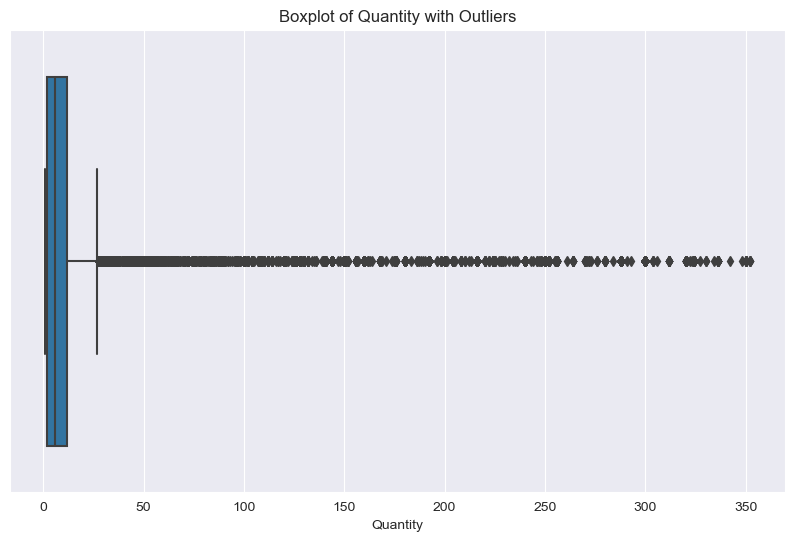

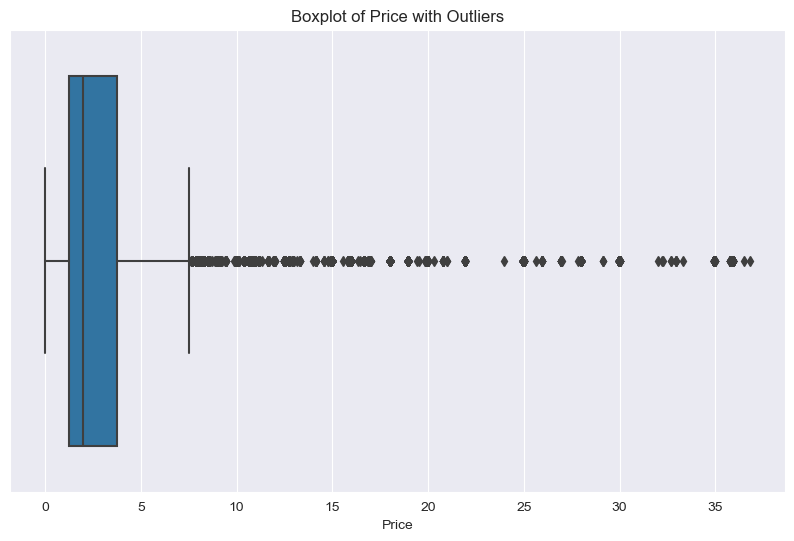

In [15]:
def plot_with_outliers(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)

    # Draw the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dataframe[variable])
    plt.title(f'Boxplot of {variable} with Outliers')
    plt.show()

# 对'Quantity'和'Price'字段分别进行绘制
plot_with_outliers(retail_df, 'Quantity')
plot_with_outliers(retail_df, 'Price')

## 4. Visualization

### 1. Top 10 Products by Quantity Sold

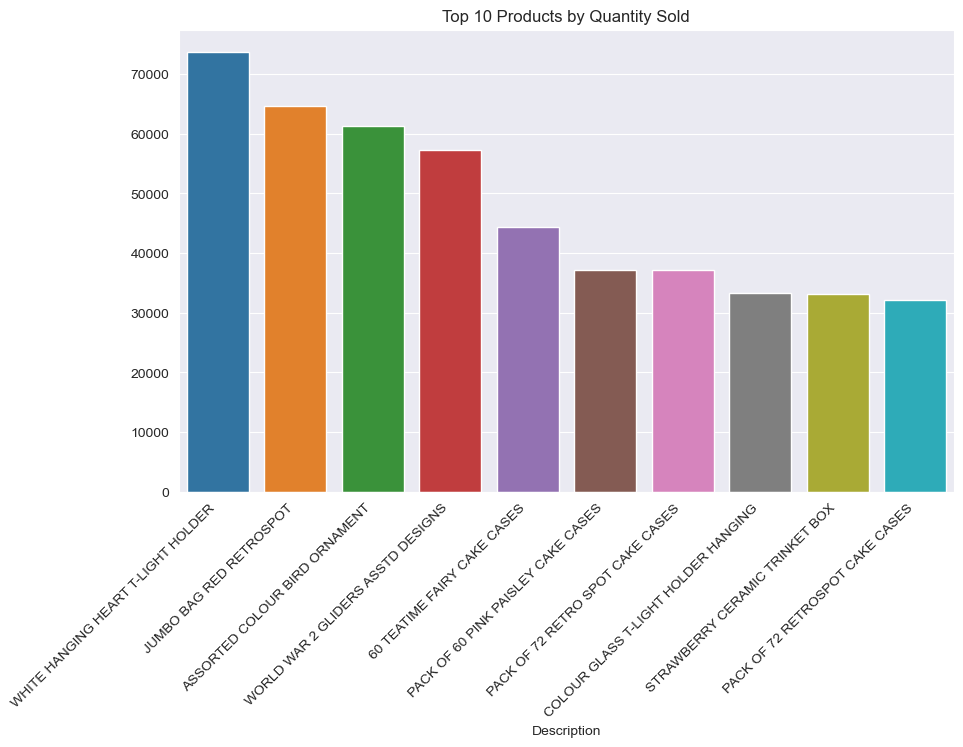

In [16]:
top_products = retail_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

### 2. Top 10 Products by Total Sales Value

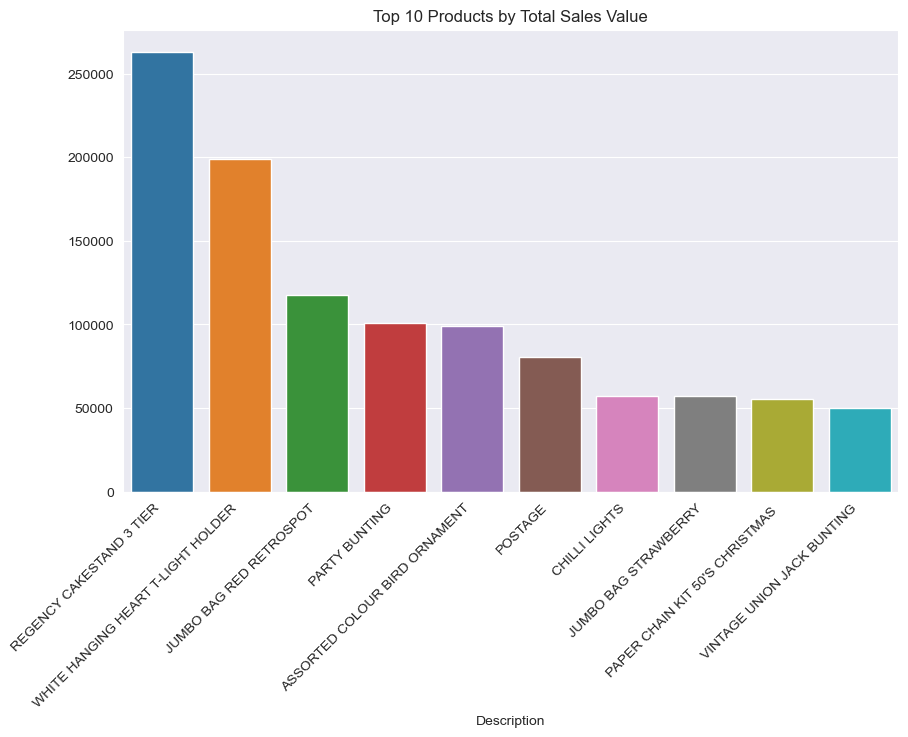

In [17]:
top_products = retail_df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Total Sales Value')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3. Top 10 Customers by Total Sales Value

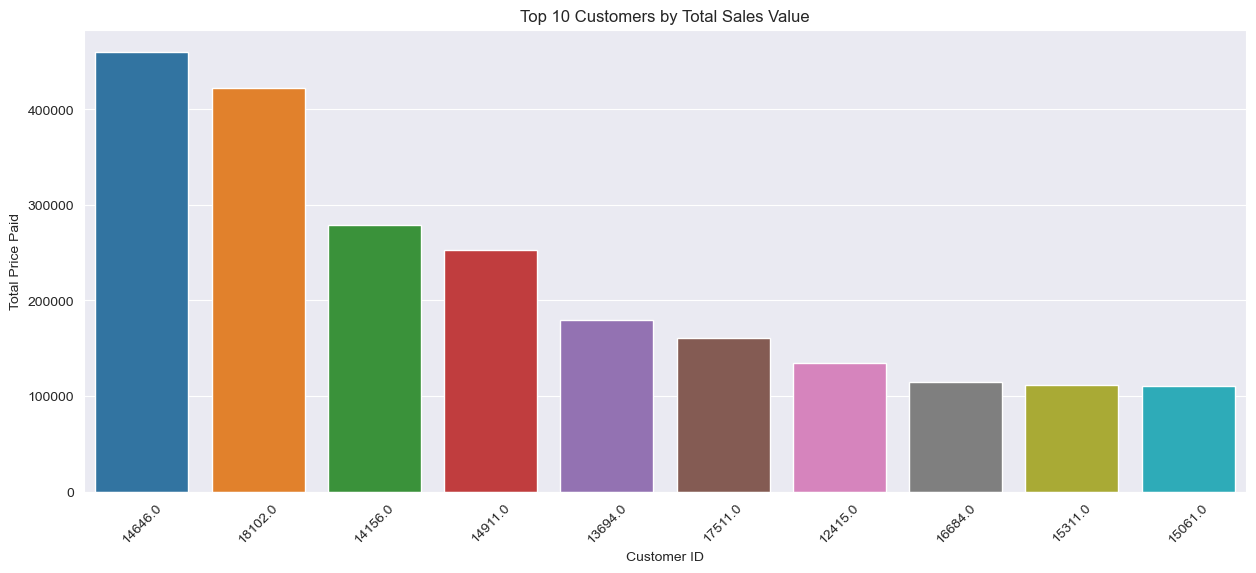

In [18]:
# Calculate total sales value for each customer
top_customers = retail_df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 6))
sns.barplot(x=top_customers.index, y=top_customers.values, order=top_customers.index)
plt.title('Top 10 Customers by Total Sales Value')
plt.xlabel('Customer ID')
plt.ylabel('Total Price Paid')
plt.xticks(rotation=45)
plt.show()

### 4. Average Spending per Customer

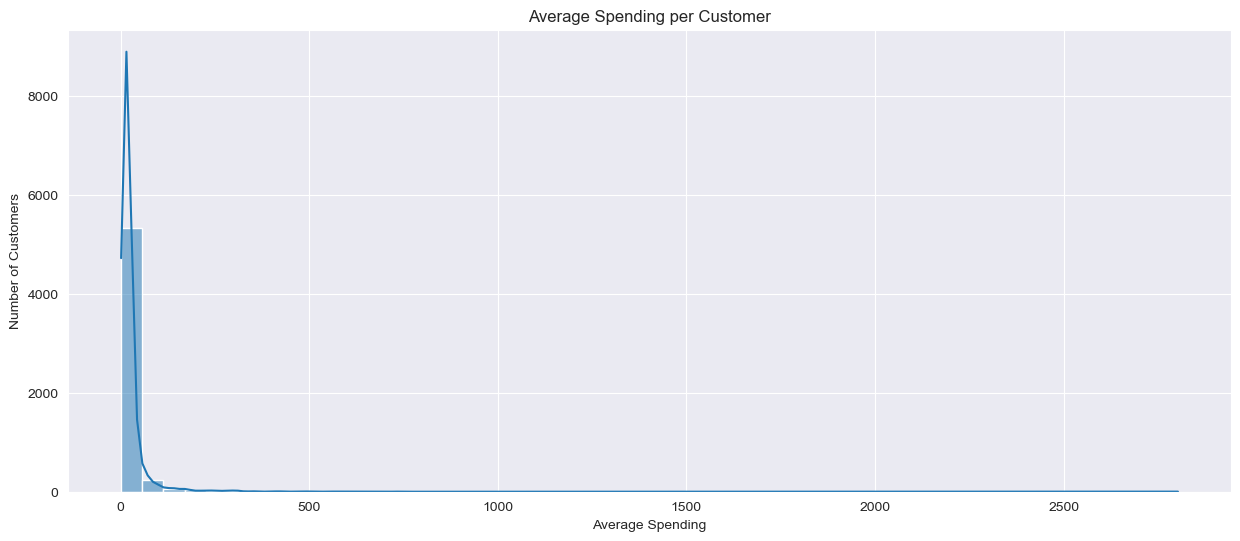

In [19]:
# Group by Customer ID and calculate average spending per customer
average_spending = retail_df.groupby('Customer ID')['TotalPrice'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.histplot(average_spending['TotalPrice'], kde=True, bins=50)
plt.title('Average Spending per Customer')
plt.xlabel('Average Spending')
plt.ylabel('Number of Customers')
plt.show()

### 5. Distribution of Quantity

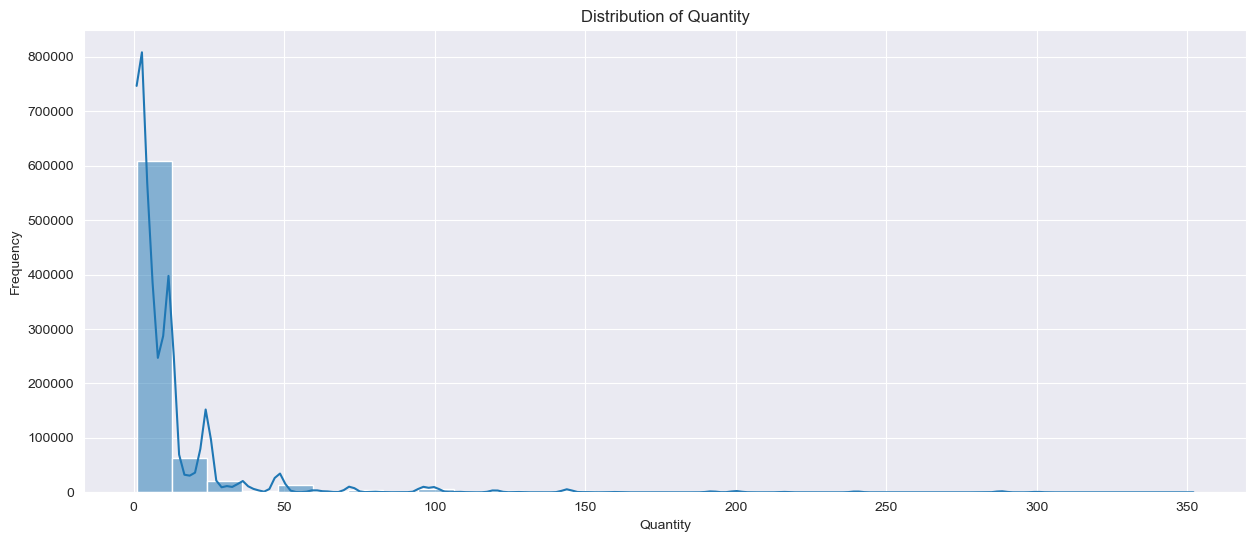

In [20]:
plt.figure(figsize=(15, 6))
sns.histplot(retail_df['Quantity'], kde=True, bins=30)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

### 6. Distribution of Total Price

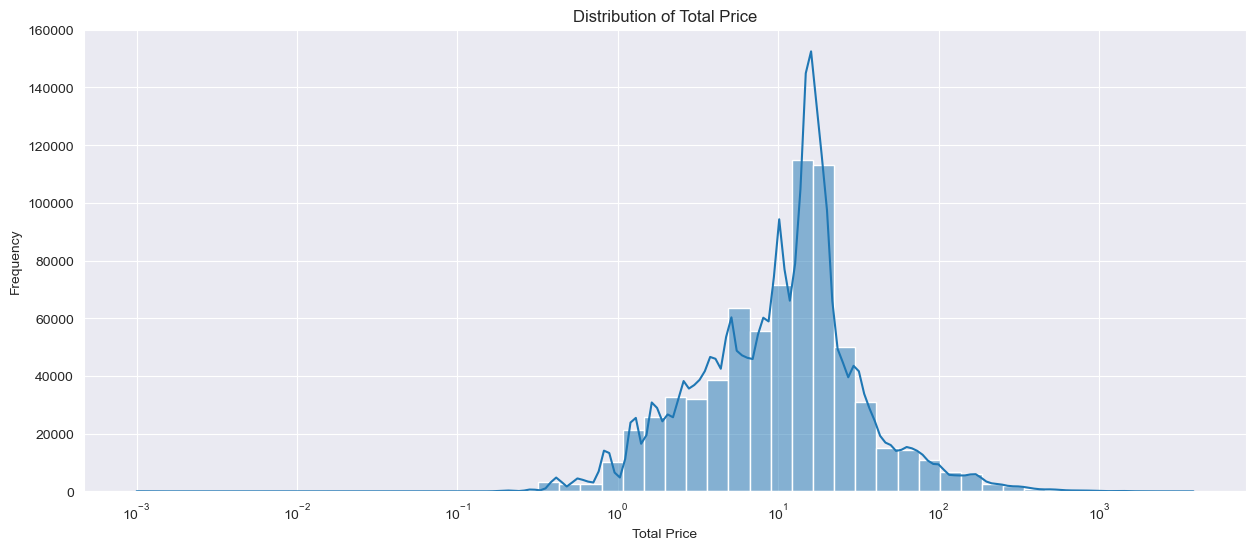

In [21]:
plt.figure(figsize=(15, 6))
sns.histplot(retail_df['TotalPrice'], kde=True, bins=50, log_scale=True)
plt.title('Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

### 7. Number of Transactions Over Time

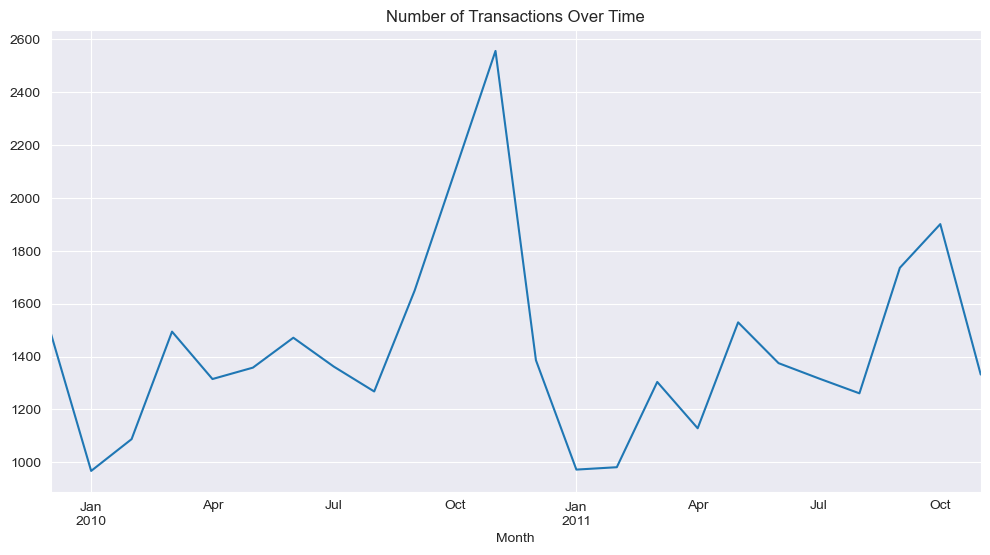

In [22]:
retail_df['Month'] = retail_df['Date'].dt.to_period('M')
transactions_per_month = retail_df.groupby('Month')['Transaction_id'].nunique()
plt.figure(figsize=(12,6))
transactions_per_month.plot(kind='line')
plt.title('Number of Transactions Over Time')
plt.show()

### 8. Sales Trend by Month

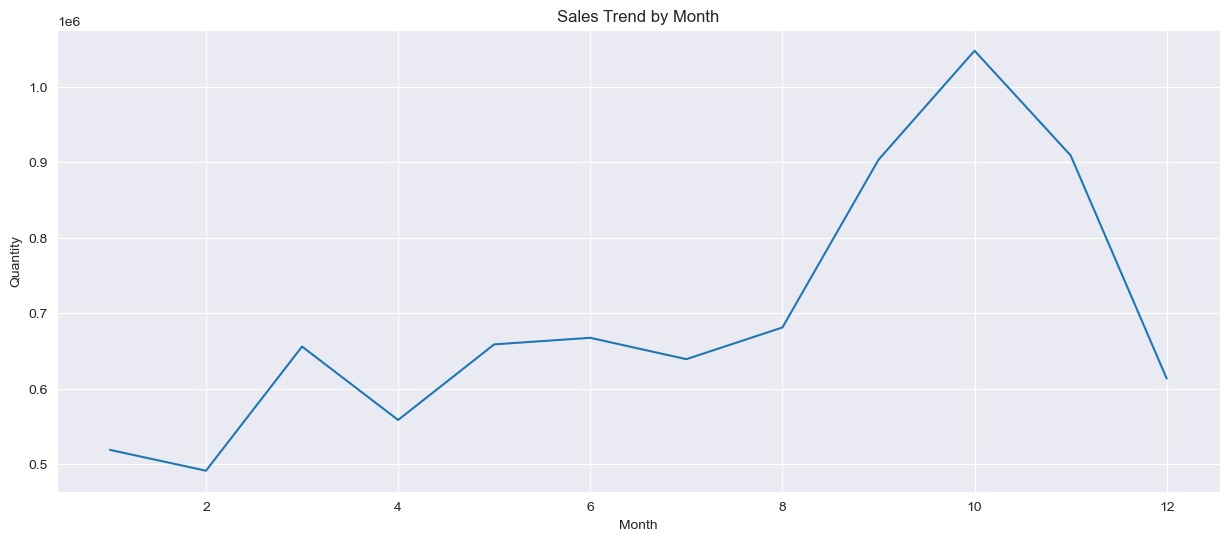

In [23]:
retail_df['Month'] = retail_df['Date'].dt.month

# Calculate total sales per month
sales_per_month = retail_df.groupby('Month')['Quantity'].sum().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Month', y='Quantity', data=sales_per_month)
plt.title('Sales Trend by Month')
plt.show()


### 9. Sales Trend by Hour

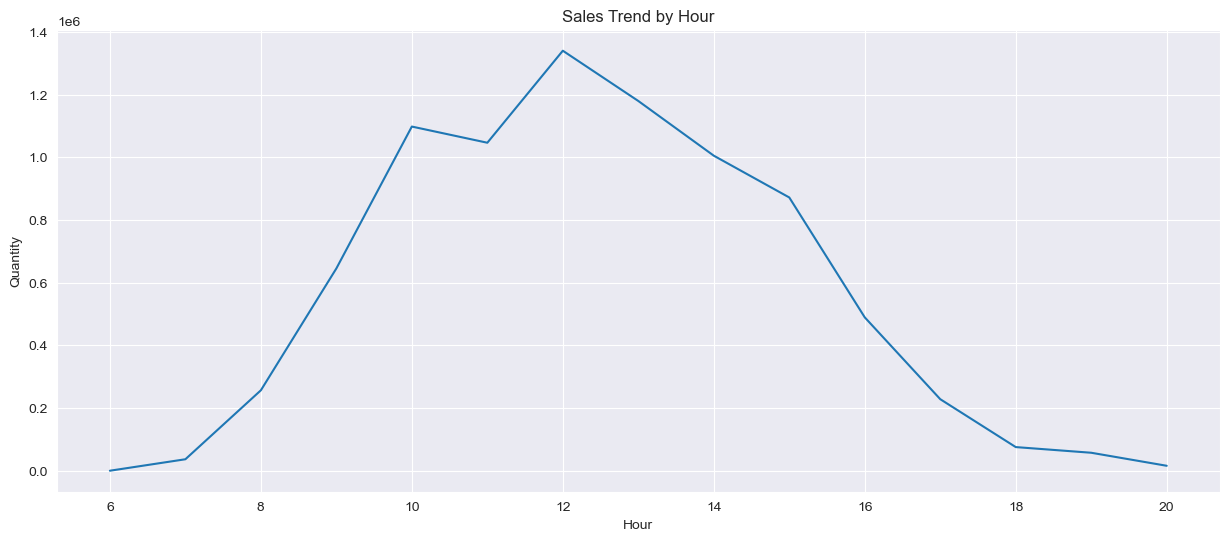

In [24]:
# Add an hour column
retail_df['Hour'] = retail_df['Date'].dt.hour

# Calculate total sales per hour
sales_per_hour = retail_df.groupby('Hour')['Quantity'].sum().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Hour', y='Quantity', data=sales_per_hour)
plt.title('Sales Trend by Hour')
plt.show()


### 10. Relationship between Quantity Sold and Total Sales Value by Product

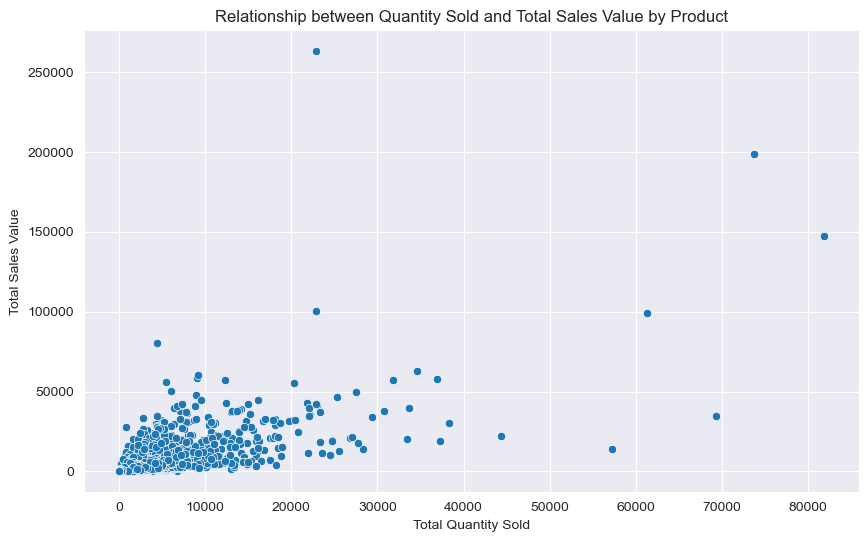

In [25]:
product_sales = retail_df.groupby('Product_id').agg({'Quantity': 'sum', 'TotalPrice': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalPrice', data=product_sales)
plt.title('Relationship between Quantity Sold and Total Sales Value by Product')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Total Sales Value')
plt.show()


### 11. Recency Distribution from RFM Analysis

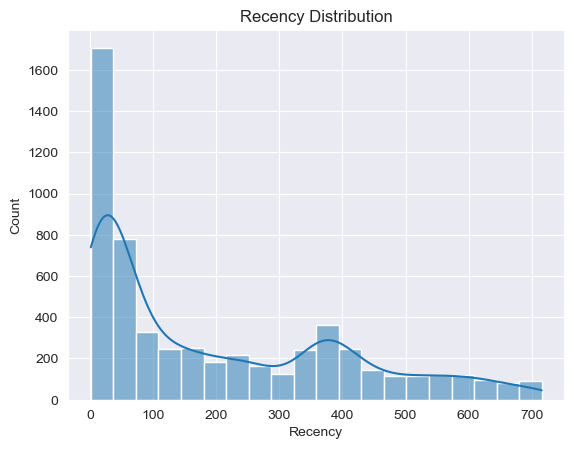

In [26]:
# Recency distribution
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')
plt.show()

### 12. Frequency Distribution from RFM Analysis

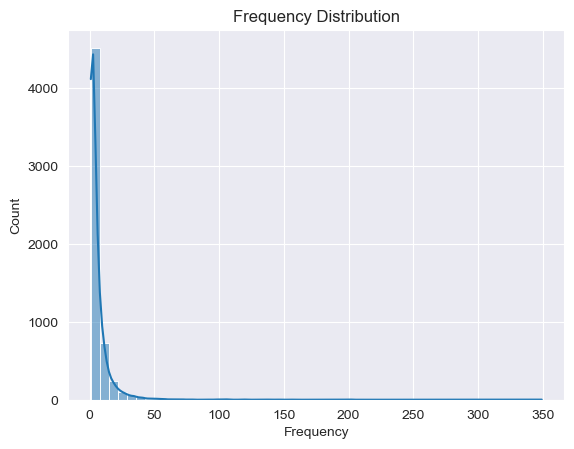

In [27]:
# Frequency distribution
sns.histplot(rfm_df['Frequency'], kde=True, bins=50)
plt.title('Frequency Distribution')
plt.show()

### 13. Monetary Distribution from RFM Analysis

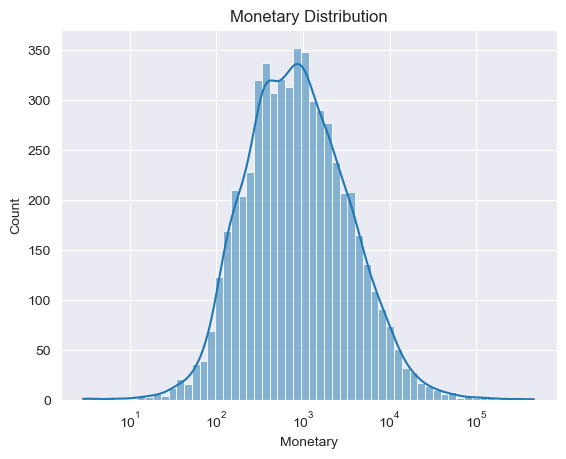

In [28]:
sns.histplot(rfm_df['Monetary'], kde=True, log_scale=(True, False))
plt.title('Monetary Distribution')
plt.show()

## 5. Using Apriori Algorithm to Find Association Rules

In [34]:
# Data Preprocessing
transactions = retail_df.groupby('Transaction_id')['Product_id'].apply(list)

# Transforming the data into the right format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [35]:
# Finding Frequent Itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

# Generating Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

In [45]:
# Filtering Rules
# Filter the DataFrame of rules to find the best ones
rules = rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]

In [46]:
rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
426,(22746),(22745),0.012784,0.015376,0.010658,0.833713,54.222924,0.010462,5.921234,0.994268
425,(22745),(22746),0.015376,0.012784,0.010658,0.693182,54.222924,0.010462,3.217593,0.996885
430,(22748),(22746),0.016977,0.012784,0.011328,0.667238,52.193548,0.011111,2.966737,0.997780
429,(22746),(22748),0.012784,0.016977,0.011328,0.886105,52.193548,0.011111,8.630939,0.993542
428,(22748),(22745),0.016977,0.015376,0.013104,0.771870,50.200764,0.012843,4.316060,0.997006
...,...,...,...,...,...,...,...,...,...,...
271,(21931),(85099B),0.048078,0.090594,0.025451,0.529376,5.843387,0.021096,1.932341,0.870729
246,(21929),(85099B),0.034479,0.090594,0.018200,0.527872,5.826780,0.015077,1.926184,0.857960
257,(21930),(85099B),0.027548,0.090594,0.014298,0.519027,5.729156,0.011803,1.890765,0.848838
433,(22804),(85123A),0.016278,0.137158,0.011881,0.729875,5.321422,0.009648,3.194230,0.825518


In [48]:
def standardize_rule(row):
    # Extract antecedents and consequents as sets
    antecedents = row['antecedents']
    consequents = row['consequents']

    # Create a combined, sorted list of all items in the rule
    all_items = sorted(list(antecedents) + list(consequents))

    # Create a standardized representation of the rule
    standardized_rule = tuple(all_items)
    return standardized_rule

# Apply the standardization function to each row
rules['standardized_rule'] = rules.apply(standardize_rule, axis=1)

# Drop duplicates based on the standardized rule
rules_dedup = rules.drop_duplicates(subset='standardized_rule')

# Optionally drop the 'standardized_rule' column if it's no longer needed
rules_dedup = rules_dedup.drop(columns=['standardized_rule'])

In [49]:
rules_dedup.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
426,(22746),(22745),0.012784,0.015376,0.010658,0.833713,54.222924,0.010462,5.921234,0.994268
430,(22748),(22746),0.016977,0.012784,0.011328,0.667238,52.193548,0.011111,2.966737,0.997780
428,(22748),(22745),0.016977,0.015376,0.013104,0.771870,50.200764,0.012843,4.316060,0.997006
739,(21094),"(21086, 21080)",0.019569,0.011474,0.010076,0.514881,44.875665,0.009851,2.037699,0.997231
192,(21240),(21239),0.016278,0.015609,0.011124,0.683363,43.781139,0.010870,3.108897,0.993329
...,...,...,...,...,...,...,...,...,...,...
271,(21931),(85099B),0.048078,0.090594,0.025451,0.529376,5.843387,0.021096,1.932341,0.870729
246,(21929),(85099B),0.034479,0.090594,0.018200,0.527872,5.826780,0.015077,1.926184,0.857960
257,(21930),(85099B),0.027548,0.090594,0.014298,0.519027,5.729156,0.011803,1.890765,0.848838
433,(22804),(85123A),0.016278,0.137158,0.011881,0.729875,5.321422,0.009648,3.194230,0.825518


In [53]:
rules_dedup['antecedents'] = rules_dedup['antecedents'].apply(lambda x: tuple(x))
rules_dedup['consequents'] = rules_dedup['consequents'].apply(lambda x: tuple(x))
rules_dedup.to_csv('../rules.csv', index=False)

In [54]:
rules_dedup.sort_values(by='lift', ascending=False).head(10).to_csv('../top10_rules.csv', index=False)